<a href="https://colab.research.google.com/github/fanyrodz/modelo_predictivo/blob/main/modelo_predictivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Cargar archivo


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score

import xgboost as xgb

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

## 2. Preparación datos

In [ ]:
contract.info()
personal.info()
internet.info()
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   D

In [ ]:
for name, df in {
    "contract": contract,
    "personal": personal,
    "internet": internet,
    "phone": phone
}.items():
    dup_count = df.duplicated(subset="customerID").sum()
    print(f"{name}: {dup_count} duplicados por customerID")

if contract.duplicated(subset="customerID").sum() > 0:
    display(contract[contract.duplicated(subset="customerID", keep=False)].sort_values("customerID"))


contract: 0 duplicados por customerID
personal: 0 duplicados por customerID
internet: 0 duplicados por customerID
phone: 0 duplicados por customerID


El numero de datos en contract y personal tienen la misma cantidad de datos, mientras que en internet y phone es menor, por lo que podemos asumir que algunos clientes no tienen internet o telefono, por lo que la unión debe ser con how='left' sobre contract para no perder registros.  
También podemos apreciar que no hay duplicados en ningun dataset.

In [ ]:
df = (
    contract
    .merge(personal, on="customerID", how="left")
    .merge(internet, on="customerID", how="left")
    .merge(phone, on="customerID", how="left")
)


In [ ]:
print("Filas en contract:", len(contract))
print("Filas después de unir:", len(df))
print("Duplicados por customerID:", df.duplicated(subset="customerID").sum())

Filas en contract: 7043
Filas después de unir: 7043
Duplicados por customerID: 0


Con esto confirmamos la integridad de la unión de los datasets

In [ ]:
print("\nResumen de tipos y nulos:")
print(df.info())
print("\nValores nulos por columna:")
print(df.isnull().sum().sort_values(ascending=False))


Resumen de tipos y nulos:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport    

Hay valores nulos esperados:

- 1,526 nulos en todas las columnas de Internet y servicios relacionados → son clientes que no tienen Internet.

- 682 nulos en MultipleLines → clientes que no tienen teléfono fijo.

Esto es totalmente lógico, ya que algunos clientes solo contratan un servicio. No es un problema de datos, sino información válida.

## 3. Preprocesamiento

In [ ]:
# Reemplazar nulos de servicios con "No"
cols_internet = [
    "InternetService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"
]
df[cols_internet] = df[cols_internet].fillna("No")

# Reemplazar nulos en servicio telefónico
df["MultipleLines"] = df["MultipleLines"].fillna("No")

# Convertir fechas a datetime
df["BeginDate"] = pd.to_datetime(df["BeginDate"])
df["EndDate"] = df["EndDate"].replace("No", pd.NaT)  # "No" significa cliente activo
df["EndDate"] = pd.to_datetime(df["EndDate"])

# Asegurar que TotalCharges sea numérico
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")


In [ ]:
# 1 = cliente cancelado
# 2 = cliente activo
df["Churn"] = df["EndDate"].notna().astype(int)


In [ ]:
# Eliminar columnas que no se usan para el modelo directamente
df_model = df.drop(columns=["customerID", "BeginDate", "EndDate"])

# Identificar variables categóricas y numéricas
cat_cols = df_model.select_dtypes(include="object").columns.tolist()
num_cols = df_model.select_dtypes(exclude="object").drop(columns=["Churn"]).columns.tolist()

# One-Hot Encoding
df_encoded = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)


In [ ]:
scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

## 4. Feature Engineering

In [ ]:
max_date = df["BeginDate"].max()

df["ContractDuration"] = np.where(
    df["EndDate"].notna(),
    (df["EndDate"] - df["BeginDate"]).dt.days,
    (max_date - df["BeginDate"]).dt.days
)

In [ ]:
service_cols = [
    "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"
]

df["NumServices"] = df[service_cols].apply(lambda x: sum(val != "No" for val in x), axis=1)

In [ ]:
df["ChargesPerService"] = df["MonthlyCharges"] / df["NumServices"].replace(0, 1)

In [ ]:
contract_map = {"Month-to-month": 0, "One year": 1, "Two year": 2}
df["ContractTypeNum"] = df["Type"].map(contract_map)

In [ ]:
df[["ContractDuration", "NumServices", "ChargesPerService", "ContractTypeNum"]].head()

,ContractDuration,NumServices,ChargesPerService,ContractTypeNum
0,31.0,2,14.925000,0
1,1036.0,3,18.983333,1
2,61.0,3,17.950000,0
3,1371.0,4,10.575000,1
4,61.0,1,70.700000,0


In [ ]:
# Revisar las nuevas columnas
print("\nVista previa de las nuevas variables creadas:")
print(df[["ContractDuration", "NumServices", "ChargesPerService", "ContractTypeNum"]].head())

# Comprobar si hay valores nulos en las nuevas variables
print("\nValores nulos en las nuevas variables:")
print(df[["ContractDuration", "NumServices", "ChargesPerService", "ContractTypeNum"]].isnull().sum())

# Estadísticas básicas para detectar valores extraños
print("\nResumen estadístico de las nuevas variables:")
print(df[["ContractDuration", "NumServices", "ChargesPerService", "ContractTypeNum"]].describe())



Vista previa de las nuevas variables creadas:
   ContractDuration  NumServices  ChargesPerService  ContractTypeNum
0              31.0            2          14.925000                0
1            1036.0            3          18.983333                1
2              61.0            3          17.950000                0
3            1371.0            4          10.575000                1
4              61.0            1          70.700000                0

Valores nulos en las nuevas variables:
ContractDuration     0
NumServices          0
ChargesPerService    0
ContractTypeNum      0
dtype: int64

Resumen estadístico de las nuevas variables:
       ContractDuration  NumServices  ChargesPerService  ContractTypeNum
count       7043.000000  7043.000000        7043.000000      7043.000000
mean         985.996166     3.243078          22.591220         0.690473
std          747.587844     2.307141          11.550318         0.833755
min            0.000000     0.000000           8.650000 

Con esta información comprobamos que no hay valores nulos en las nuevas variables (ContractDuration, NumServices, ChargesPerService, ContractTypeNum) y que los valores tienen sentido:

- ContractDuration: desde 0 días (clientes nuevos) hasta ~6 años (2191 días).

- NumServices: de 0 a 8 (coincide con la cantidad de servicios posibles).

- ChargesPerService: valores positivos, sin outliers extremos raros.

- ContractTypeNum: 0, 1, 2 → correcto para contrato mes a mes, 1 año, 2 años.

## 5. Modelado y validación

In [ ]:
X = df.drop(columns=["Churn", "customerID", "BeginDate", "EndDate"])
y = df["Churn"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

In [ ]:
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

In [ ]:
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    # IMPORTANTE: en tu versión usa 'sparse=False' (no 'sparse_output')
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False)),
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
], remainder="drop")

In [ ]:
baseline_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))  # si hay aviso, usar solver="liblinear"
])

In [ ]:
baseline_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'SeniorCitizen',
                                                   'ContractDuration',
                                                   'NumServices',
                                                   'ChargesPerService',
                                                   'ContractTypeNum']),
                                                 ('cat',
                       

In [ ]:
y_pred_proba = baseline_model.predict_proba(X_test)[:, 1]
y_pred = baseline_model.predict(X_test)

auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)

print(f"AUC-ROC (baseline LR): {auc:.4f}")
print(f"Accuracy (baseline LR): {acc:.4f}")


AUC-ROC (baseline LR): 0.8420
Accuracy (baseline LR): 0.8077


In [ ]:
rf_fast = Pipeline([
    ("preprocessor", preprocessor),  # el mismo del baseline
    ("classifier", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features="sqrt",
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ))
])

rf_fast.fit(X_train, y_train)
proba = rf_fast.predict_proba(X_test)[:, 1]
pred  = rf_fast.predict(X_test)

print("AUC-ROC (RF rápido):", roc_auc_score(y_test, proba))
print("Accuracy (RF rápido):", accuracy_score(y_test, pred))


AUC-ROC (RF rápido): 0.8498566224908937
Accuracy (RF rápido): 0.7913413768630234


In [ ]:
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

num_pipe_tree = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

cat_pipe_tree = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False)),
])

preprocessor_tree = ColumnTransformer([
    ("num", num_pipe_tree, num_cols),
    ("cat", cat_pipe_tree, cat_cols),
], remainder="drop")

X_train_proc = preprocessor_tree.fit_transform(X_train)
X_test_proc  = preprocessor_tree.transform(X_test)

pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos if pos > 0 else 1.0
print("scale_pos_weight:", round(scale_pos_weight, 3))

xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight
)

xgb_model.fit(
    X_train_proc, y_train,
    eval_set=[(X_test_proc, y_test)],
    verbose=False,
    early_stopping_rounds=50
)

proba_xgb = xgb_model.predict_proba(X_test_proc)[:, 1]
pred_xgb  = (proba_xgb >= 0.5).astype(int)

auc_xgb = roc_auc_score(y_test, proba_xgb)
acc_xgb = accuracy_score(y_test, pred_xgb)

print(f"AUC-ROC (XGBoost): {auc_xgb:.4f}")
print(f"Accuracy (XGBoost): {acc_xgb:.4f}")
print("Best n_estimators (after early stopping):", xgb_model.best_iteration+1 if hasattr(xgb_model, "best_iteration") else "N/A")


scale_pos_weight: 2.769


/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AUC-ROC (XGBoost): 0.9048
Accuracy (XGBoost): 0.8361
Best n_estimators (after early stopping): 990


## 6. Evaluación

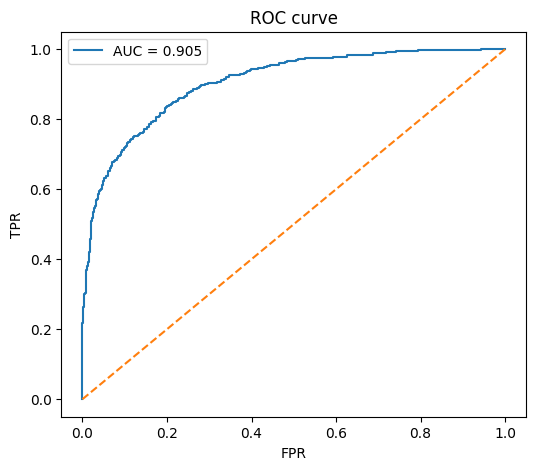

In [ ]:
proba = proba_xgb
auc = roc_auc_score(y_test, proba)

fpr, tpr, thr = roc_curve(y_test, proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.legend()
plt.show()


In [ ]:
j_scores = tpr - fpr
best_ix = np.argmax(j_scores)
best_thr = thr[best_ix]
print("Umbral óptimo (Youden J):", round(best_thr, 4))

pred_opt = (proba >= best_thr).astype(int)
cm = confusion_matrix(y_test, pred_opt)
print("Matriz de confusión (umbral óptimo):\n", cm)
print("\nClassification report (umbral óptimo):")
print(classification_report(y_test, pred_opt, digits=3))

Umbral óptimo (Youden J): 0.3801
Matriz de confusión (umbral óptimo):
 [[829 206]
 [ 61 313]]

Classification report (umbral óptimo):
              precision    recall  f1-score   support

           0      0.931     0.801     0.861      1035
           1      0.603     0.837     0.701       374

    accuracy                          0.811      1409
   macro avg      0.767     0.819     0.781      1409
weighted avg      0.844     0.811     0.819      1409



In [ ]:

num_features = num_cols

ohe = preprocessor_tree.named_transformers_["cat"].named_steps["ohe"]
if hasattr(ohe, "get_feature_names_out"):
    cat_features = ohe.get_feature_names_out(cat_cols)
else:
    cat_features = ohe.get_feature_names(cat_cols)

feature_names = np.concatenate([np.array(num_features, dtype=object), np.array(cat_features, dtype=object)])

importances = xgb_model.feature_importances_
assert len(importances) == len(feature_names), f"{len(importances)} importancias vs {len(feature_names)} nombres"

top_idx = np.argsort(importances)[::-1][:15]
for i in top_idx:
    print(f"{feature_names[i]:50s}  {importances[i]:.4f}")


Type_Month-to-month                                 0.2699
ContractTypeNum                                     0.1564
InternetService_Fiber optic                         0.1209
InternetService_No                                  0.0610
StreamingMovies_Yes                                 0.0284
StreamingTV_Yes                                     0.0265
StreamingMovies_No                                  0.0213
PaymentMethod_Electronic check                      0.0195
ContractDuration                                    0.0179
Type_Two year                                       0.0157
TechSupport_Yes                                     0.0135
InternetService_DSL                                 0.0134
StreamingTV_No                                      0.0132
Type_One year                                       0.0127
OnlineSecurity_Yes                                  0.0116


In [ ]:

Path("models").mkdir(parents=True, exist_ok=True)

artifact = {
    "preprocessor": preprocessor_tree,
    "model": xgb_model
}
joblib.dump(artifact, "models/churn_xgb_artifact.pkl", compress=3)
print(" Modelo guardado en: models/churn_xgb_artifact.pkl")

loaded = joblib.load("models/churn_xgb_artifact.pkl")
X_test_proc_chk = loaded["preprocessor"].transform(X_test)
proba_loaded = loaded["model"].predict_proba(X_test_proc_chk)[:, 1]

print("¿Probas iguales a las previas? ", np.allclose(proba_loaded, proba_xgb))
print("AUC-ROC con cargado:", roc_auc_score(y_test, proba_loaded))


 Modelo guardado en: models/churn_xgb_artifact.pkl
¿Probas iguales a las previas?  True
AUC-ROC con cargado: 0.9047689167893772
